# **I. Environment setup**

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import mne
from Dataset import Dataset
from EEGProcessor import EEGProcessor

In [2]:
import matplotlib
%matplotlib inline

# **II. Preprocessing**
## **1. Some information on the current dataset**
* **Task**: Classification for 6 mental states of passive, left and right-hand, left and right-leg, and tongue movements
* **Methods**:
    * 3 BCI interation segments, each with a 2-minute break, form one recording session.
    * Participants are given 2.5 minutes at the beginning to acclimatize to the recording session's conditions.
    * Afterwards, each interaction segment is administered for 15 minutes.
$\rightarrow$ **EEG data is continuously measured for a total length of 50 - 55 minutes.**
* **Data acquisitions**
    * **No electromagnetic shielding or artifact control** was attempted for the recordings.
    * Out of 22 channels used, the 2 ground leads are labeled $A_1$ and $A_2$. $X_3$ is used for data synchronization.
    * Hardware filters of $0.53 - 70 Hz$ and $0.53 - 100 Hz$ are applied for EEG data recorded at sampling rates of $200 Hz$ and $1000 Hz$ respectively.
    * A $50Hz$ notch filter is also applied to reduce electrical grid interference.
    * **No terminal motion and E&M-related interference** occurred during data collection.
    * **All electrode impedances were below specified levels** at the start and end of the recording session, and no other technical issues were present.
    * **Post-hoc modifications** of data of any kinds were **not applied** to present researchers with the raw-est data possible. 

## **2. Data extraction and formatting**

In [3]:
my_dataset = Dataset("MotorImageryEEG\\data\\HaLTSubjectF1602026StLRHandLegTongue.mat")
my_dataset.extract_file()
my_dataset.format_data()
my_dataset.add_montage()

Creating RawArray with float64 data, n_channels=22, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.


## **3. Removing bad channels (interpolation if needed)**
The most common way to detect "bad" channels is through visualization. We can either:
* Plot the raw data **(If the data is really large, considered not do this)**
* Plot the Power Spectrum Density (PSD) of each channel to detect for outliers

Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


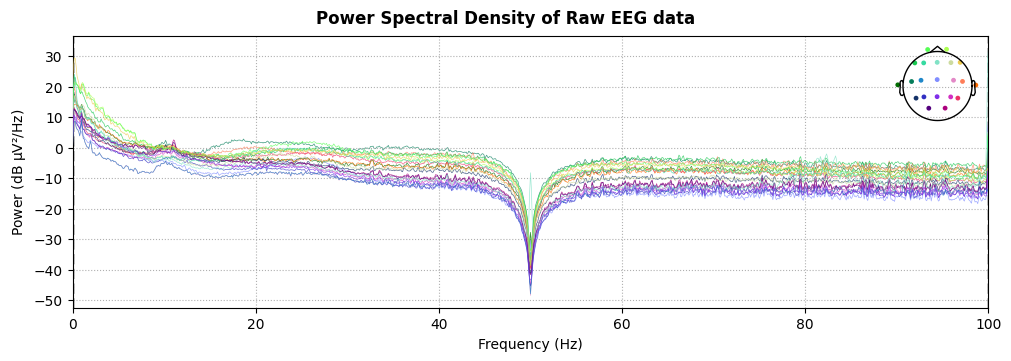

In [4]:
processor = EEGProcessor(my_dataset)
processor.plot_psd("Power Spectral Density of Raw EEG data")

## **4. Filtering**
A bandpass filter of $0.53 - 70Hz$ is already built in the hardware. Thus, we can skip this step. 

## **5. Re-referencing**

In [5]:
processor.cleaned_data.set_eeg_reference(["A1", "A2"])
processor.raw.set_eeg_reference(["A1", "A2"])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawArray | 21 x 667000 (3335.0 s), ~106.9 MB, data loaded>

## **6. Artifact detection**

In [6]:
# EOG and ECG channels must be set first before detection and correction!
processor.set_eog_channel()
processor.set_ecg_channel()

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.
Added the following bipolar channels:
EOG
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.
Added the following bipolar channels:
EOG
Creating RawArray with float64 data, n_channels=1, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.


### **6.1. EOG (Electro-oclugraphy) artifacts**

Using EOG channel: EOG
EOG channel index for this subject is: [21]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 89 significant peaks
Number of EOG events detected: 89


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 401 original time points ...
0 bad epochs dropped


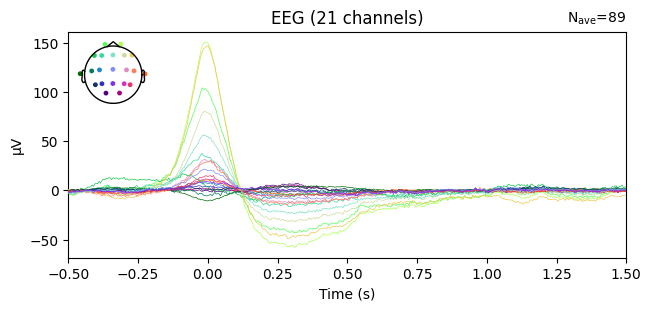

In [7]:
processor.detect_eog("Average EOG event before removal")

### **6.2. ECG (Electrocardiography) artifacts**

Using channel ECG to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2000 samples (10.000 s)

Number of ECG events detected : 5452 (average pulse 98.08695652173913 / min.)
Not setting metadata
5452 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5452 events and 401 original time points ...
0 bad epochs dropped


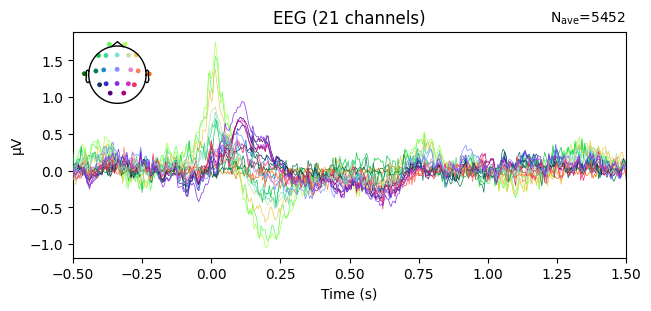

In [8]:
processor.detect_ecg("Average ECG event before removal")

## **7. Artifact correction using ICA**
ICA works best on continuous data. So you shouldn't divide your data into epochs before this process.

In [9]:
processor.remove_artifacts(method = "fastica")

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 21 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished


Selecting by non-zero PCA components: 20 components
Fitting ICA took 18.6s.
Using EOG channel: EOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Using threshold: 0.36 for CTPS ECG detection
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2000 samples (10.000 s)

Number of ECG events detected : 5235 (average pulse 94.18290854572713 / min.)
Not setting metadata
5235 matching events found
No baseline correction applied
Using data from preloaded Raw for 5235 events and 201 original time points ...
0 bad epochs dropped
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 21 PCA components


### **7.1. ICA components**
It's clear from the picture here that the **3 and 13** components are removed

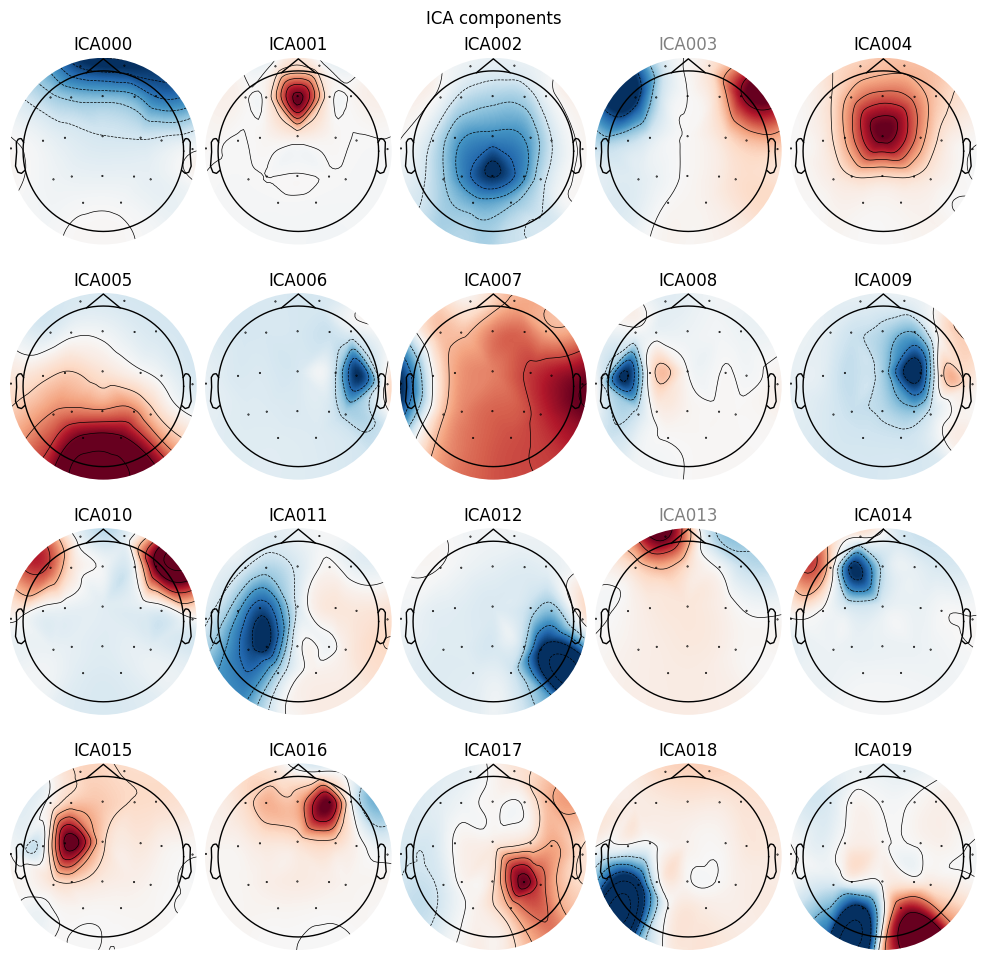

In [10]:
processor.ica.plot_components()
plt.show()
plt.close("all")

### **7.2. Overlay of raw and cleaned signals**
For the visualization of data quality and artifact rejection

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 21 PCA components


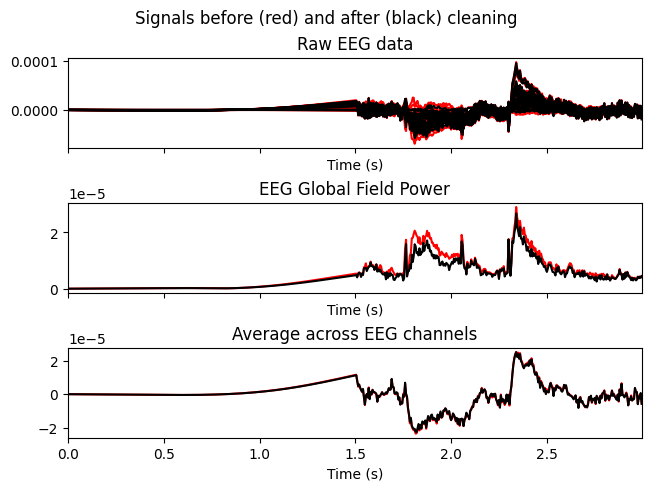

In [11]:
processor.raw.filter(l_freq = 1, h_freq = None)
processor.ica.plot_overlay(processor.raw, exclude = processor.ica.exclude)
plt.show()
plt.close("all")

### **7.3. The Power Spectral Density after cleaning**

Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


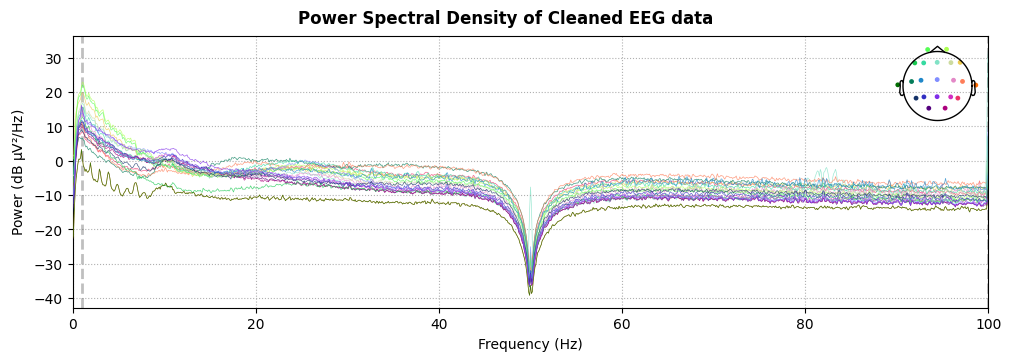

In [12]:
processor.plot_psd("Power Spectral Density of Cleaned EEG data")

### **7.4. EOG artifacts after cleaning**

Using EOG channel: EOG
EOG channel index for this subject is: [21]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 89 significant peaks
Number of EOG events detected: 89


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 401 original time points ...
0 bad epochs dropped


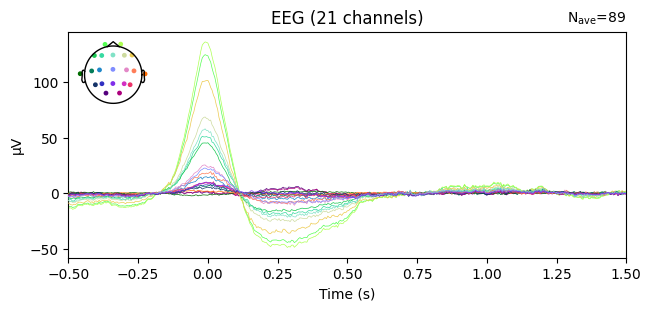

In [14]:
processor.detect_eog("Average EOG artifact after removal")

### **7.5. ECG artifacts after cleaning**

Using channel ECG to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2000 samples (10.000 s)

Number of ECG events detected : 5452 (average pulse 98.08695652173913 / min.)
Not setting metadata
5452 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5452 events and 401 original time points ...
0 bad epochs dropped


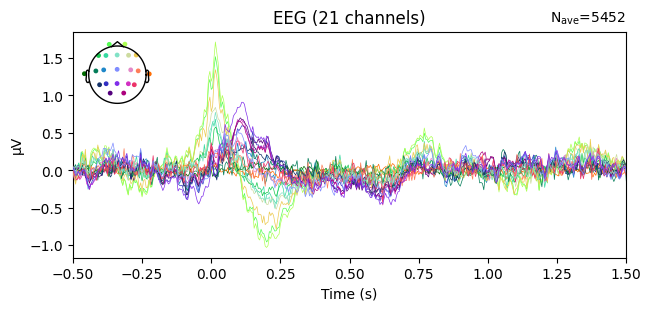

In [15]:
processor.detect_ecg("Average ECG artifacts after removal")

# **Problem**: The number of EOG and ECG artifacts don't reduce even after ICA is applied

## **8. Saving the cleaned data**

In [ ]:
processor.cleaned_data.save("cleaned_data.fif", overwrite=True)

Writing c:\Users\LENOVO\Desktop\Lab\MotorImageryEEG\..\cleaned_data.fif


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23440\4169349060.py:1: RuntimeWarning: This filename (c:\Users\LENOVO\Desktop\Lab\MotorImageryEEG\..\cleaned_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_cleaned.save("..\\cleaned_data.fif", overwrite=True)


Closing c:\Users\LENOVO\Desktop\Lab\MotorImageryEEG\..\cleaned_data.fif
[done]
